### Kaggle Data Science BOWL 2017 

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import cv2
import scipy.ndimage as ndimage
from sklearn.cross_validation import KFold
from skimage import measure, morphology, segmentation
#from mpl_toolkits.mplot3d.art3d import Poly3DCollection

import dicom
%matplotlib inline
p = sns.color_palette()
import time

# get package versions
def get_version(*vars):
    for var in vars:
        module = __import__(var)    
        print '%s: %s' %(var,module.__version__)
    
# package version    
get_version('numpy','matplotlib','cv2','sklearn','skimage','scipy')

numpy: 1.11.2
matplotlib: 1.5.1
cv2: 3.1.0
sklearn: 0.18.1
skimage: 0.12.3
scipy: 0.18.1


/home/mra/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### presets

In [4]:
path2data='../sample_images/'
#path2data='../stage1/'
path2data='/media/mra/My Passport/Kaggle/datascience2017/data/stage1/'
patients=os.listdir(path2data)
patients.sort()
print len(patients)

path2output='./output/data/'

# dispaly
display_ena=False

# resize
h,w=512,512

1595


### Functions

In [5]:
# Load dicom files
def load_scan(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

def array_stats(X):
    X=np.asarray(X)
    print 'array shape: ',X.shape, X.dtype
    #print 'min: %.3f, max:%.3f, avg: %.3f, std:%.3f' %(np.min(X),np.max(X),np.mean(X),np.std(X))
    print 'min: {}, max: {}, avg: {:.3}, std:{:.3}'.format( np.min(X),np.max(X),np.mean(X),np.std(X))
    
# Some of the starting Code is taken from ArnavJain, since it's more readable then my own
def generate_markers(image):
    H,W=image.shape
    
    #Creation of the internal Marker
    marker_internal = image < -400
    marker_internal = segmentation.clear_border(marker_internal)
    marker_internal_labels = measure.label(marker_internal)
    areas = [r.area for r in measure.regionprops(marker_internal_labels)]
    areas.sort()
    
    # pick top three regions
    nb_regions=3
    if len(areas) > nb_regions:
        for region in measure.regionprops(marker_internal_labels):
            if region.area < areas[-nb_regions]:
                for coordinates in region.coords:                
                    marker_internal_labels[coordinates[0], coordinates[1]] = 0
    #marker_internal = marker_internal_labels > 0

    # remove regions near the border
    #deltas = [H-np.max(d.coords) for d in measure.regionprops(marker_internal_labels)]
    #deltas.sort()
    #nb_regions=2
    #if len(deltas) > nb_regions:
    #    for region in measure.regionprops(marker_internal_labels):
    #        delta=H-np.max(region.coords)
    #        if delta < deltas[-nb_regions]:
    #            for coordinates in region.coords:                
    #                marker_internal_labels[coordinates[0], coordinates[1]] = 0
    #marker_internal = marker_internal_labels > 0
    
    
    #Creation of the external Marker
    external_a = ndimage.binary_dilation(marker_internal, iterations=10)
    external_b = ndimage.binary_dilation(marker_internal, iterations=55)
    marker_external = external_b ^ external_a
    
    #Creation of the Watershed Marker matrix
    marker_watershed = np.zeros((H, W), dtype=np.int)
    marker_watershed += marker_internal * 255
    marker_watershed += marker_external * 128
    
    marker_out=[marker_internal,marker_external,marker_watershed]
    return marker_out

def seperate_lungs(image):
    #Creation of the markers as shown above:
    marker_internal, marker_external, marker_watershed = generate_markers(image)
    
    #Creation of the Sobel-Gradient
    sobel_filtered_dx = ndimage.sobel(image, 1)
    sobel_filtered_dy = ndimage.sobel(image, 0)
    sobel_gradient = np.hypot(sobel_filtered_dx, sobel_filtered_dy)
    sobel_gradient *= 255.0 / np.max(sobel_gradient)
    
    #Watershed algorithm
    watershed = morphology.watershed(sobel_gradient, marker_watershed)
    
    #Reducing the image created by the Watershed algorithm to its outline
    outline = ndimage.morphological_gradient(watershed, size=(3,3))
    outline = outline.astype(bool)
    
    #Performing Black-Tophat Morphology for reinclusion
    #Creation of the disk-kernel and increasing its size a bit
    blackhat_struct = [[0, 0, 1, 1, 1, 0, 0],
                       [0, 1, 1, 1, 1, 1, 0],
                       [1, 1, 1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1, 1, 1],
                       [0, 1, 1, 1, 1, 1, 0],
                       [0, 0, 1, 1, 1, 0, 0]]
    blackhat_struct = ndimage.iterate_structure(blackhat_struct, 8)
    #Perform the Black-Hat
    outline += ndimage.black_tophat(outline, structure=blackhat_struct)
    
    #Use the internal marker and the Outline that was just created to generate the lungfilter
    lungfilter = np.bitwise_or(marker_internal, outline)
    #Close holes in the lungfilter
    #fill_holes is not used here, since in some slices the heart would be reincluded by accident
    lungfilter = ndimage.morphology.binary_closing(lungfilter, structure=np.ones((5,5)), iterations=3)
    
    #Apply the lungfilter (note the filtered areas being assigned -2000 HU)
    segmented = np.where(lungfilter == 1, image, -2000*np.ones((512, 512)))
    
    out=[segmented, lungfilter, outline, watershed, sobel_gradient,\
                     marker_internal, marker_external, marker_watershed]
    return out


### Get data stats

array shape:  (1595,) int64
min: 94, max: 541, avg: 1.79e+02, std:67.0
Total patients 1595 Total DCM files 285380


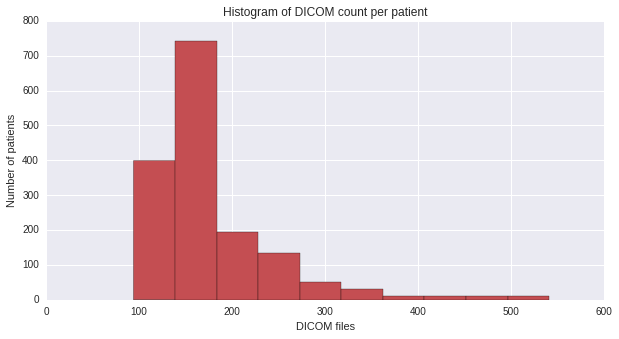

In [6]:
print 'wait ...'
nb_dicoms=[]
for d in patients:
    #print("Patient '{}' has {} scans".format(d, len(os.listdir(path2data + d))))
    nb_dicoms.append(len(os.listdir(path2data + d)))

array_stats(nb_dicoms)    
print('Total patients {} Total DCM files {}'.format(len(patients), len(glob.glob(path2data+'*/*.dcm'))))

plt.figure(figsize=((10,5)))
plt.hist(nb_dicoms, color=p[2])
plt.ylabel('Number of patients')
plt.xlabel('DICOM files')
plt.title('Histogram of DICOM count per patient')
plt.show()

### Training stats

In [7]:
df_train = pd.read_csv('../stage1_labels.csv')
print('Number of training patients: {}'.format(len(df_train)))
print('Cancer rate: {:.4}%'.format(df_train.cancer.mean()*100))
df_train.head()


Number of training patients: 1397
Cancer rate: 25.91%


,id,cancer
0,0015ceb851d7251b8f399e39779d1e7d,1
1,0030a160d58723ff36d73f41b170ec21,0
2,003f41c78e6acfa92430a057ac0b306e,0
3,006b96310a37b36cccb2ab48d10b49a3,1
4,008464bb8521d09a42985dd8add3d0d2,1


In [6]:
# stack images and labels
def stack_data(df,indices,(h,w)):
    X=[]
    Y=[]
    y=[]
    for r in (indices):
        # get patinet id and cancer status
        p_id=df_train.id[r] # patient id
        p_c=df_train.cancer[r] # patinet cancer

        # load scan
        scan=load_scan(path2data+p_id)
        X1 = get_pixels_hu(scan)
        nb_slices=len(X1)
        N,H,W=X1.shape
        
        # get lung segmentation
        #print 'wait ....'
        Y1=np.zeros_like(X,'uint8')
        for slice_nm in range(len(X1)):
            masks=seperate_lungs(X[slice_nm])
            Y1[slice_nm]=masks[1]
        
        # resize
        if h<H:
            Xr=np.zeros((nb_slices,h,w),dtype=X1.dtype)
            Yr=np.zeros((nb_slices,h,w),dtype=Y1.dtype)
            for k1 in range(nb_slices):
                Xr[k1]=cv2.resize(X1[k1], (w, h), interpolation=cv2.INTER_CUBIC)
                Yr[k1]=cv2.resize(Y1[k1], (w, h), interpolation=cv2.INTER_CUBIC)
        else:
            Xr=X1
            Yr=Y1
        print 'patient %s id: %s, cancer: %s, nb slices: %s' %(r,p_id,p_c,Xr.shape[0])        
        X.append(Xr)
        Y.append(Yr)
        y.append(p_c)
    return X,y  

## sample patinet with cancer

patient id: a79023a82079a7431ef2496acbef29de, cancer: 0
array shape:  (175, 512, 512) int16
min: -1024, max: 3070, avg: -4.92e+02, std:4.86e+02
wait ....
array shape:  (175, 512, 512) uint8
min: 0, max: 1, avg: 4.3e-05, std:0.00655


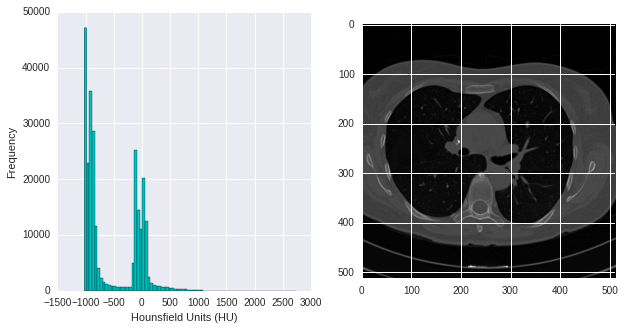

In [27]:
r=np.random.randint(len(patients)) # row

# get patinet id and cancer status
p_id=df_train.id[r] # patient id
p_c=df_train.cancer[r] # patinet cancer
print 'patient id: %s, cancer: %s' %(p_id,p_c)

# load scan
scan=load_scan(path2data+p_id)
X = get_pixels_hu(scan)
array_stats(X)

# get lung segmentation
print 'wait ....'
Y1=np.zeros_like(X,'uint8')
for slice_nm in range(2):
    masks=seperate_lungs(X[slice_nm])
    Y1[slice_nm]=masks[1]
array_stats(Y1)

sn=70
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.hist(X[sn].flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")

# Show some slice in the middle
plt.subplot(1,2,2)
plt.imshow(X[sn], cmap=plt.cm.gray)
plt.show()

# get pixel spacing 

In [26]:
# Load spacing values (in mm)
RefDs=scan[0]
ConstPixelSpacing = (float(RefDs.PixelSpacing[0]), float(RefDs.PixelSpacing[1]), float(RefDs.SliceThickness))
print ConstPixelSpacing

(0.7265625, 0.7265625, 2.0)


In [28]:
if display_ena is True:
    nb_slices=len(X)
    r,c=nb_slices/5,5
    f, plots = plt.subplots(r, c, sharex='all', sharey='all', figsize=(c*3, r*3))
    print 'wait ...'
    for i in range(nb_slices):
        plots[i // c, i % c].axis('off')
        plots[i // c, i % c].imshow(X[i], cmap=plt.cm.bone)

In [9]:
if display_ena is True:
    nb_slices=len(X)
    r,c=nb_slices/5,5
    f, plots = plt.subplots(r, c, sharex='all', sharey='all', figsize=(c*3, r*3))
    print 'wait ...'
    for i in range(nb_slices):
        plots[i // c, i % c].axis('off')
        plots[i // c, i % c].imshow(Y1[i], cmap=plt.cm.bone)

## sample patinet non-cancer

patient id: 0030a160d58723ff36d73f41b170ec21, cancer: 0
array shape:  (265, 512, 512) int16
min: -1024, max: 3072, avg: -5.25e+02, std:4.85e+02


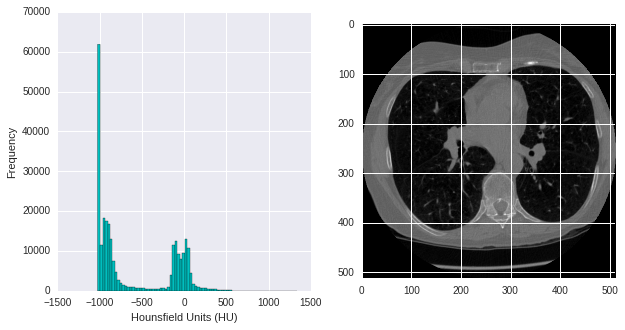

In [10]:
r=1 # row

# get patinet id and cancer status
p_id=df_train.id[r] # patient id
p_c=df_train.cancer[r] # patinet cancer
print 'patient id: %s, cancer: %s' %(p_id,p_c)

# load scan
scan=load_scan(path2data+p_id)
X = get_pixels_hu(scan)
array_stats(X)

sn=len(X)/2
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.hist(X[sn].flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")

# Show some slice in the middle
plt.subplot(1,2,2)
plt.imshow(X[sn], cmap=plt.cm.gray)
plt.show()

### Downsample

In [11]:
# transpose to h,w,z
X=np.transpose(X,(1,2,0))
# resize
Xr=cv2.resize(X, (w, h), interpolation=cv2.INTER_CUBIC)
# transpose to z,h,w
Xr=np.transpose(Xr,(2,0,1))
array_stats(Xr)

array shape:  (265, 512, 512) int16
min: -1024, max: 3072, avg: -5.25e+02, std:4.85e+02


In [12]:
if display_ena is True:
    r,c=nb_slices/5,5
    f, plots = plt.subplots(r, c, sharex='all', sharey='all', figsize=(15, 120))
    print 'wait ...'
    for i in range(nb_slices):
        plots[i // c, i % c].axis('off')
        plots[i // c, i % c].imshow(Xr[i], cmap=plt.cm.bone)

## save as numpy

In [13]:
start_time=time.time()

# total subjects
nb_sbj=len(df_train)

h,w=512,512

for p in range(nb_sbj):
    
    # get patinet id and cancer status
    p_id=df_train.id[p] # patient id
    print 'processing patient %s, wait ...' %p_id
    y=df_train.cancer[p] # patinet cancer

    # load scan
    scan=load_scan(path2data+p_id)
    X = get_pixels_hu(scan)
    nb_slices=len(X)
    N,H,W=X.shape
        
    # get lung segmentation
    Y=np.zeros_like(X,'uint8')
    for slice_nm in range(nb_slices):
        masks=seperate_lungs(X[slice_nm])
        Y[slice_nm]=masks[1]

    array_stats(X)
    array_stats(Y)
    array_stats(y)
    
    print 'wait to save ...'
    # create folder 
    path2numpy=path2output+'numpy/'
    if  not os.path.exists(path2numpy):
        os.makedirs(path2numpy)
        print 'folder created'
    np.savez(path2numpy+df_train.id[p], X=X,Y=Y,y=y)
    
    #print 'patient %s saved' %p 
    print '-' *50

elapsed_time=(time.time()-start_time)
print ('elapsed time: %.2d sec' %(elapsed_time))    

processing patient 0015ceb851d7251b8f399e39779d1e7d, wait ...
array shape:  (195, 512, 512) int16
min: -1024, max: 3071, avg: -6.3e+02, std:4.93e+02
array shape:  (195, 512, 512) uint8
min: 0, max: 1, avg: 0.162, std:0.369
array shape:  () int64
min: 1, max: 1, avg: 1.0, std:0.0
wait to save ...
--------------------------------------------------
processing patient 0030a160d58723ff36d73f41b170ec21, wait ...
array shape:  (265, 512, 512) int16
min: -1024, max: 3072, avg: -5.25e+02, std:4.85e+02
array shape:  (265, 512, 512) uint8
min: 0, max: 1, avg: 0.231, std:0.421
array shape:  () int64
min: 0, max: 0, avg: 0.0, std:0.0
wait to save ...
--------------------------------------------------
processing patient 003f41c78e6acfa92430a057ac0b306e, wait ...


KeyboardInterrupt: 

In [ ]:
## verify

In [23]:
f=np.load(path2numpy+df_train.id[p]+'.npz')
print f.keys()
X=f['X']
Y=f['Y']
y=f['y']
array_stats(X)
array_stats(Y)
array_stats(y)

['Y', 'X', 'y']
array shape:  (233, 512, 512) int16
min: -1024, max: 2002, avg: -4.14e+02, std:4.68e+02
array shape:  (233, 512, 512) uint8
min: 0, max: 1, avg: 0.174, std:0.379
array shape:  () int64
min: 0, max: 0, avg: 0.0, std:0.0


In [ ]:
## save as joblib to accelerate

In [28]:
from sklearn.externals import joblib

start_time=time.time() 
# Dump the created data to disk
joblib.dump(X,path2numpy+'/images.joblib')
elapsed_time=(time.time()-start_time)
print ('elapsed time: %.3d sec' %(elapsed_time))        

start_time=time.time() 
np.savez(path2numpy+'t1',X=X)
elapsed_time=(time.time()-start_time)
print ('elapsed time: %.1d sec' %(elapsed_time))        


elapsed time: 000 sec
elapsed time: 1 sec
